# **<center>NBA SALARY PROBABILITY PREDICTION</center>**

_by Giacomo Berselli_

### **1. INTRODUCTION**

Determining the factors that influence National Basketball Association (NBA) owners to pay players has always been of great importance in light of financial constraints such as the NBA salary cap. Furthermore, in recent years it has been the players themselves who decided to assume teams of data scientists because interested in what variables affect their salaries and how, in order to evaluate if they were adequate or not. Therefore, the aim of this project is to understand the relationship between a player's characteristics, his statistics and his annual salary, to understand if and which players receive a higher or lower salary than their peers. In addition, this work could also be of great importance in understanding whether race discrimination exists, as each player's nationality has been considered as a variable.

The task was done by collecting the official data of the players in the 2020-2021 year from the official website of the NBA and that of ESPN. Then the database was processed through a Bayesian Network, which allowed me to deal with uncertainty and partial information, and to make probabilistic predictions by defining probabilities of different causes that could affect my target in a very simplified model of my domain of interest.

### **2. IMPORT DATA**

In [1028]:
import os
import pandas as pd
from pgmpy.inference import VariableElimination
from pgmpy.models import BayesianNetwork
from pgmpy.sampling import BayesianModelSampling
import matplotlib.pylab as plt
import networkx as nx
import numpy as np
#from functions import *
import matplotlib.pylab as plt
import networkx as nx

The data used in the project were taken from the following sites:
- Players regular season stats: National Basketball Association (NBA) official site [link](https://www.nba.com/stats/players/traditional/?sort=PLAYER_NAME&dir=-1&Season=2020-21&SeasonType=Regular%20Season)
- Players info: Real GM [link](https://basketball.realgm.com/nba/players/2021)
- Players salary: ESPN & Spotrac [link1](https://www.spotrac.com/nba/rankings/2020-21/cap-hit/) [link2](http://www.espn.com/nba/salaries/_/year/2021)

I've collected them in two .csv files in order to easily load them in the notebook and then apply the necessary preprocessing.

In [1029]:
# IMPORT DATAFRAMES AS .CSV FILES
df_stats = pd.read_csv('NBA_Stats_20-21.csv',delimiter=';')
df_info = pd.read_csv('NBA_Players_Info_20-21.csv',delimiter=';')
df_info.drop(['AGE','TEAM','GP'], axis = 1, inplace = True) # drop these columns because repeated

df_original = pd.merge(df_stats, df_info, on=['PLAYER'], how='left')

COLUMNS_TO_DROP = ['PLAYER', 'W', 'L', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 
                    'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'FP', 'DD2', 'TD3', 'COLLEGE',
                    'PTS', 'STL', 'AST', 'PF', 'TOV', 'REB', 'BLK']

ATLANTIC = ['BOS','BKN','NYK','PHI','TOR']
CENTRAL = ['CHI','CLE','DET','IND','MIL']
SOUTHEAST = ['ATL', 'MIA', 'WAS','CHA', 'ORL']
NORTHWEST = ['DEN','MIN','OKC','POR','UTA']
PACIFIC = ['GSW','LAC','LAL','PHX','SAC']
SOUTHWEST = [ 'DAL','MEM', 'SAS', 'NOP', 'HOU']

### **3. PREPROCESSING**

In [1030]:
df_original.head() # print the whole dataframe

,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,+/-,PER,POS,HEIGHT,WEIGHT,YOS,COLLEGE,DRAFT,COUNTRY,SALARY
0,Aaron Gordon,DEN,25,50,29,21,27.7,12.4,4.6,10.0,...,1.2,14.59,F,6-8,235,6,Arizona,2014 Rnd 1 Pick 4,United States,"$18,136,364"
1,Aaron Holiday,IND,24,66,30,36,17.8,7.2,2.6,6.6,...,0.0,9.29,PG,6-0,185,2,UCLA,2018 Rnd 1 Pick 23,United States,"$2,345,640"
2,Aaron Nesmith,BOS,21,46,22,24,14.5,4.7,1.7,3.9,...,-0.2,9.46,F,6-6,213,0,Vanderbilt,2020 Rnd 1 Pick 14,United States,"$3,458,400"
3,Abdel Nader,PHX,27,24,16,8,14.8,6.7,2.4,4.8,...,1.2,13.43,SF,6-6,225,3,Iowa State,2016 Rnd 2 Pick 28,United States,"$1,752,950"
4,Adam Mokoka,CHI,22,14,3,11,4.0,1.1,0.5,1.4,...,-0.6,2.30,SG,6-5,215,1,Other,"2019 NBA Draft, Undrafted",France,"$449,115"


As we can see, some of the categories are not numerical, but Bayesian Networks are algebraic, so the input must be numerical. Thus to use the model these categories must be tranformed into numbers first, before applying the learning algorithm on them. In addition, other ones are useless for our purpose, so it is clear how a preprocessing step is fundamental before using the database as input of the network. In the next cell the database is manipulated as follows:
- `DRAFT`: identifies if a player has been drafted in a pick of the first round (1), of the second round (2) or is never drafted to enter in the league (3).
- `TEAM`: teams are divided based on their geographical location and an integer is associated to each region.
- `POS`: player's roles are divided into the 5 fundamental positions of basketball.
- `COUNTRY`: splits US players (2) and foreign players (1).
- `AGE`, `HEIGHT`, `WEIGHT`, `MIN`, `GP`: identify respectively the age of a player, his height and weight, the minutes per game he played in the 20-21 regular season and the number of games played. All these variables are already numerical so the values are simply splitted in bins.
- `YOS`: indicates the amount of career years played in the league. The possible values are splitted in 4 bins.
- `PER`: the Player Efficiency Rating (PER) is a rating system developed by John Hollinger that aims to create a summative rating of each player in the NBA. It takes into account points signed, rebounds, assists, turnovers, steals, blocks, personal fouls and many other variables per game, and produce as output a weighted rating for each player. It is recognized as a good parameter to evaluate the efficiency of a player, so in this project it is used in place of the previous variables in order to not make the network too slow. Since the PER outcome is already an integer and could not be negative, the values start from 0 and are divided into 6 bins.
- `+/-`: computes the performance of the team when a player is playing on the parquet. Thus a positive `+/-` means that the team scored more points than the opponent, and viceversa. This is again a numerical variable which is simply splitted into 6 labels.
- `SALARY`: since it represents the variable we are interested in, I've decided to split it into 8 different labels. In addition, the ranges are not equally distributed because most of the players in the league have a salary incredibly lower with respect to the top 10 NBA players, so more weight is given to the salaries less than 10 millions of USD to equally distribute the players inside the bins.

In [1031]:
# PREPROCESSING
if not os.path.exists('NBA_Dataframe.CSV'):
        
        # DROP USELESS COLUMNS
        df = df_original.drop(COLUMNS_TO_DROP, axis = 1)

        for i in range(df.shape[0]):
                # DRAFT (First round -> 1, Second round -> 2, Undrafted -> 3)
                if ' 1 ' in str(df.loc[i,'DRAFT']): df.loc[i,'DRAFT'] = 1
                elif ' 2 ' in str(df.loc[i,'DRAFT']): df.loc[i,'DRAFT'] = 2
                else: df.loc[i,'DRAFT'] = 3

                # TEAM (ATLANTIC -> 1, CENTRAL -> 2, SOUTHEAST -> 3, NORTHWEST -> 4, PACIFIC -> 5, SOUTHWEST -> 6)
                if df.loc[i,'TEAM'] in ATLANTIC: df.loc[i,'TEAM'] = 1
                elif df.loc[i,'TEAM'] in CENTRAL: df.loc[i,'TEAM'] = 2
                elif df.loc[i,'TEAM'] in SOUTHEAST: df.loc[i,'TEAM'] = 3
                elif df.loc[i,'TEAM'] in NORTHWEST: df.loc[i,'TEAM'] = 4
                elif df.loc[i,'TEAM'] in PACIFIC: df.loc[i,'TEAM'] = 5
                elif df.loc[i,'TEAM'] in SOUTHWEST: df.loc[i,'TEAM'] = 6

                # PG (point guard) -> 1, G -> 1, SG (shooting guard) -> 2, SF (small forward) -> 3,
                # GF -> 3, PF (power forward) -> 4, F -> 4, C (center) -> 5,  FC -> 5.
                if df.loc[i,'POS'] == 'PG' or df.loc[i,'POS'] == 'G': df.loc[i,'POS'] = 1
                elif df.loc[i,'POS'] == 'SG': df.loc[i,'POS'] = 2
                elif df.loc[i,'POS'] == 'SF' or df.loc[i,'POS'] == 'GF': df.loc[i,'POS'] = 3
                elif df.loc[i,'POS'] == 'PF' or df.loc[i,'POS'] == 'F': df.loc[i,'POS'] = 4
                else: df.loc[i,'POS'] = 5

                height_nums = [int(value) for value in str(df.loc[i,'HEIGHT']).split('-')]
                height_nums[1] += height_nums[0] * 12
                h_cm = int(height_nums[1] * 2.54)
                df.loc[i,'HEIGHT'] = h_cm

        # COUNTRY (NOT('United States') -> 1, 'United States' -> 2)
        df.loc[df['COUNTRY'] != 'United States', 'COUNTRY'] = 1
        df.loc[df['COUNTRY'] == 'United States', 'COUNTRY'] = 2

        # AGE (RANGES: (-INF)-24 -> 1, 25-29 -> 2, 30-34 -> 3,  35-INF -> 4)
        df['AGE'] = pd.cut(df['AGE'], bins=[-np.inf, 24, 29, 34, np.inf], labels=[1,2,3,4])
        
        # HEIGHT (RANGES: (-INF)-179 -> 1, 180-189 -> 2, 190-199 -> 3, 200-209 -> 4, 210-INF -> 5)
        df['HEIGHT'] = pd.cut(df['HEIGHT'], bins=[-np.inf, 179, 189, 199, 209, np.inf], labels=[1,2,3,4,5])

        # WEIGHT (RANGES: (-INF)-199 -> 1, 200-219 -> 2, 220-239 -> 3, 240-259 -> 4, 260-INF -> 5)
        df['WEIGHT'] = pd.cut(df['WEIGHT'], bins=[-np.inf, 199, 219, 239, 259, np.inf], labels=[1,2,3,4,5])

        # MIN (RANGES: (-INF)-4 -> 1, 5-9 -> 2, 10-14 -> 3, 15-19 -> 4, 20-24 -> 5, 25-29 -> 6, 30-INF -> 7)
        df['MIN'] = pd.cut(df['MIN'], bins=[-np.inf, 4, 9, 14, 19, 24, 29, np.inf], labels=[1,2,3,4,5,6,7])

        # GAMES PLAYED
        df['GP'] = pd.cut(df['GP'], bins=[-np.inf, 19, 39, 59, np.inf], labels=[1,2,3,4])

        # YEARS IN THE LEAGUE (RANGES: (-INF)-4 -> 1, 5-9 -> 2, 10-14 -> 3, 15-INF -> 4)
        df['YOS'] = pd.cut(df['YOS'], bins=[-np.inf, 3, 6, 9, np.inf], labels=[1,2,3,4])

        # PLAYER EFFICIENCY RATING (RANGES: (-INF)-4 -> 1, 5-9 -> 2, 10-14 -> 3, 15-19 -> 4, 20-24 -> 5, 25-INF -> 6)
        df['PER'] = pd.cut(df['PER'], bins=[-np.inf, 4, 9, 14, 19, 24, np.inf], labels=[1,2,3,4,5,6])

        # +/- (RANGES: (-INF)-(-11) -> 1, (-10)-(-6) -> 2, (-5)-(-1) -> 3, 0-4 -> 4, 5-9 -> 5, 10-INF -> 6)
        df['+/-'] = pd.cut(df['+/-'], bins=[-np.inf, -5, -2, 0, 2, 5, np.inf], labels=[1,2,3,4,5,6])

        # PLAYER SALARY (RANGES: (-INF)-4M -> 1, 5M-9M -> 2, 10M-14M -> 3, 15M-19M -> 4, 20M-24M -> 5, 25M-29M -> 6
        # 30M-34M -> 7, 35M-39M -> 8, 40M-INF -> 9)
        df['SALARY'] = df['SALARY'].str.replace(r'\D', '', regex = True).astype(int)
        df['SALARY'] = pd.cut(df['SALARY'], 
                              bins=[-np.inf, 1000000, 3000000, 5000000, 7000000, 9000000, 19000000, 29000000, np.inf], 
                              labels=[1,2,3,4,5,6,7,8])

Now that we have made the preprocessing phase, we can save the database as .csv file, to inspect it deeper if required.

In [1032]:
# SAVE DATAFRAME AND SHOW
if not os.path.exists('NBA_Dataframe.CSV'):
    df.to_csv('NBA_Dataframe.CSV', sep=',', na_rep='NaN', index=False)
else:
    df = pd.read_csv('NBA_Dataframe.CSV')

df.head()

,TEAM,AGE,GP,MIN,+/-,PER,POS,HEIGHT,WEIGHT,YOS,DRAFT,COUNTRY,SALARY
0,4,2,3,6,4,4,4,4,3,2,1,2,6
1,2,1,4,4,3,3,1,2,1,1,1,2,2
2,1,1,3,4,3,3,4,3,2,1,1,2,3
3,5,2,2,4,4,3,3,3,3,1,2,2,2
4,2,1,1,1,3,1,2,3,2,1,3,1,1


The database seems to be processed correctly because no error raised. The only problem that can be occurred and that cannot be detected is that some values are not present between the ranges of the bins of some categories, producing a NaN as output. To be sure that this didn't happen, we can check if NaNs are present in the freshly created dataframe.

In [1033]:
print("Are there NaNs in the dataframe?", "Yes" if True in df.isnull() else "No")

Are there NaNs in the dataframe? No


### **4. BAYESIAN NETWORK CONSTRUCTION**

We can proceed by building the Bayesian Network.

In [1034]:
#defining the network structure 
model = BayesianNetwork([('AGE','YOS'), ('AGE','GP'), ('COUNTRY','YOS'), ('YOS','MIN'), ('DRAFT','MIN'), ('GP','+/-'), ('MIN','+/-'), 
                        ('HEIGHT','POS'), ('WEIGHT','POS'), ('MIN','PER'), ('POS','PER'), ('TEAM','PER'), ('TEAM','+/-'),
                        ('PER','SALARY'), ('+/-','SALARY')])

# Fit data to model
model.fit(df)

# Enter if model is incorrect
if not model.check_model():
    print("Incorrect model!")

Let's plot the network.

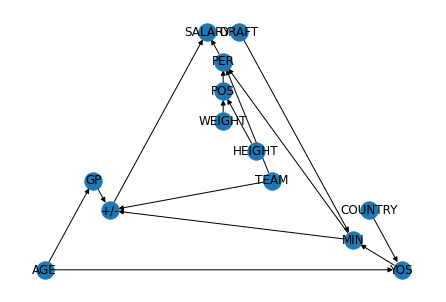

In [1035]:
#show the topology of the network (for a better visualization look in the report)
nx.draw_planar(model,with_labels=True)
plt.show()

Great, the network has been built well. We can print one of the Conditional Probability Distribution (CPD) tables to understand how it is made and how it works.

In [1036]:
# Create CPD
cpd = model.get_cpds('POS')
print(cpd)

+--------+-----------+-----------+-----+----------------------+
| HEIGHT | HEIGHT(1) | HEIGHT(1) | ... | HEIGHT(5)            |
+--------+-----------+-----------+-----+----------------------+
| WEIGHT | WEIGHT(1) | WEIGHT(2) | ... | WEIGHT(5)            |
+--------+-----------+-----------+-----+----------------------+
| POS(1) | 1.0       | 0.2       | ... | 0.0                  |
+--------+-----------+-----------+-----+----------------------+
| POS(2) | 0.0       | 0.2       | ... | 0.0                  |
+--------+-----------+-----------+-----+----------------------+
| POS(3) | 0.0       | 0.2       | ... | 0.0                  |
+--------+-----------+-----------+-----+----------------------+
| POS(4) | 0.0       | 0.2       | ... | 0.058823529411764705 |
+--------+-----------+-----------+-----+----------------------+
| POS(5) | 0.0       | 0.2       | ... | 0.9411764705882353   |
+--------+-----------+-----------+-----+----------------------+


By looking for instance to the first cell of the table, we can say that the probability for a player to be a Point Guard (PG) or a Guard (G) given that it has an height less than 180 cm and a weight less than 200 lbs is of 100%. On the other side, the probability for a player to be a Center (C/FC) given that it has an height greater than 210 cm and a weight greater than 260 lbs is approximately of 94%. These results are reasonably correct, thus the network seems to produce the right CPDs.

The notion of independence is a key in the power of Bayesian networks. They can in fact represent essentially any full joint probability distribution very concisely if each node is conditionally independent of its other predecessors given its parents.

Independence assertions are usually based on knowledge of the domain. They can dramatically reduce the amount of information necessary to specify the full joint distribution and so the complexity of the inference problem. Unfortunately, a clean separation of entire sets of variables by independence is quite rare. Bayesian networks leverage conditional independence between variables, given other variables. Conditional independence assertions are brought by direct causal relationships in the domain and can allow probabilistic systems to scale up; moreover, they are much more commonly available than absolute independence assertions.

To understand how independence works in Bayesian Networks, we can start by showing the local independencies of nodes `YOS` and `+/-`:

In [1037]:
#local independencies 
print(model.local_independencies('YOS'))
print(model.local_independencies('+/-'))

(YOS ⟂ HEIGHT, GP, POS, TEAM, WEIGHT, DRAFT | COUNTRY, AGE)
(+/- ⟂ PER, AGE, WEIGHT, HEIGHT, YOS, POS, DRAFT, COUNTRY | MIN, TEAM, GP)


As we can see, given their parents, the nodes are independent from all the other ones which can not be reached directly.

Another important independence property is implied by the topology of the network semantics: a node is conditionally independent of all other nodes in the network, given its parents, children, and children’s parents (given its Markov Blanket).

In this case we can print the Markov Blanket of the node `+/-` :

In [1038]:
#markov blanket 
model.get_markov_blanket('+/-')

['PER', 'MIN', 'SALARY', 'GP', 'TEAM']

In particular, the nodes `TEAM`, `GP` and `MIN` are the parents, `SALARY` is the children, while `PER` is the children's parent.

Now that we know how independence works in Bayesian Networks, we can use the method `active_trail_nodes` of `pgmpy`. By calling it on the node `AGE`, we can determine if exists an active trail between this one and all the nodes of network, showing as output the set of these nodes.

In [1039]:
#check d-separation 
print(model.active_trail_nodes('AGE'))
print(model.active_trail_nodes('AGE', observed='PER'))

{'AGE': {'PER', 'SALARY', '+/-', 'YOS', 'MIN', 'GP', 'AGE'}}
{'AGE': {'+/-', 'AGE', 'MIN', 'WEIGHT', 'HEIGHT', 'SALARY', 'GP', 'YOS', 'POS', 'TEAM', 'DRAFT', 'COUNTRY'}}


An important aspect to notice is that by introducing an observed node, the number of nodes reachable with an active trail increase. In this case in fact, by introducing `PER` as observed node, the nodes `POS`, `HEIGHT` and `WEIGHT` could be reached by an active trail starting from `AGE`, while this wasn't true previously.

Now let's see if it really exists an active trail between `AGE` and `PER`, and then what happened if we insert as observed node `MIN`:

In [1040]:
# Check for d-separation between variables
print(model.is_dconnected('AGE', 'PER'))
print(model.is_dconnected('AGE', 'PER', observed=['MIN']))

True
False


So it has been confirmed that the two previous nodes are d-connected, but as we expected if we insert a third node in the active trail the connection is no longer true.

### **5. INFERENCE**

In this section, I will try to fulfill the purpose of the project. The idea behind is to start by computing the salaries obtained by possessing certain characteristics, and from there go back to the players with salaries clearly different from the average. At this point it will be made an analysis of the differences between these players and players with an adequate salary, in order to understand if exists a valid reason for such an important difference or not. The second purpose is more statistical and concerns a more general analysis of the players' characteristics. Predictions will be made on the career expectancy in the league or on the probability of injuries with age, for example.

We can start by defining two functions that will be used to inference different type of probabilities from the network.
`exact_inference` computes analytically the posterior probability distribution for a set of query variables, given some
observed event, while `approximate_inference` approximates the posterior probability distribution in some way, often
with sampling methods. To perform exact inference, I used the `VariableElimination` algorithm of `pgmpy`, which is more efficient with respect to inference by enumeration. Bayesian Networks are very useful for making predictions, following the relationship between variables in the causal direction, as well as for diagnostic reasons, when we perceive as evidence some effect that we want to explain by determining its probable cause.

In [1041]:
# Create exact inference using variable elimination
exact_inference = VariableElimination(model)
# Create approximate inference using bayesian model
# approximate_inference = BayesianModelSampling(model)

##### **5.1 SALARY INFERENCE**

Let's start by computing the salary's probabilities for a player with `PER = 6` and `+/- = 5`.

In [1042]:
query1 = exact_inference.query(['SALARY'], evidence = {'PER':6,'+/-':5}, show_progress = False)
print(query1)

+-----------+---------------+
| SALARY    |   phi(SALARY) |
+===========+===============+
| SALARY(1) |        0.1000 |
+-----------+---------------+
| SALARY(2) |        0.1000 |
+-----------+---------------+
| SALARY(3) |        0.0000 |
+-----------+---------------+
| SALARY(4) |        0.0000 |
+-----------+---------------+
| SALARY(5) |        0.1000 |
+-----------+---------------+
| SALARY(6) |        0.2000 |
+-----------+---------------+
| SALARY(7) |        0.0000 |
+-----------+---------------+
| SALARY(8) |        0.5000 |
+-----------+---------------+


The CPT shows that the 50% of the players has a salary greater than 30M of dollars, which is the higher range of the league. This result is expected since having such a high PER and +/- means being among the best athletes in the league. Nevertheless, there are also small probabilities not only to have a salary slighly lower, but also among the lowest in the NBA.

Let's start by comparing the characteristics of players with `SALARY = 5`, `SALARY = 6` and `SALARY = 8`:

In [1043]:
df_temp = df.loc[((df['SALARY'] == 5) | (df['SALARY'] == 6) | (df['SALARY'] == 8)) & (df['PER'] == 6) & (df['+/-'] == 5)]
df_temp.head(10)

,TEAM,AGE,GP,MIN,+/-,PER,POS,HEIGHT,WEIGHT,YOS,DRAFT,COUNTRY,SALARY
81,3,2,4,7,5,6,4,4,4,2,1,1,6
93,4,3,4,7,5,6,1,2,1,3,1,2,8
229,1,3,3,7,5,6,2,3,3,4,1,2,8
257,3,3,3,7,5,6,3,4,3,3,1,2,8
264,6,2,4,6,5,6,5,5,5,3,1,1,6
324,1,2,3,7,5,6,1,2,1,3,1,2,8
339,6,1,4,7,5,6,3,4,3,1,1,1,5
470,5,3,4,7,5,6,1,3,1,4,1,2,8


The main difference is in the country!

Now let's compare the characteristics of players with `SALARY = 1`, `SALARY = 2` and `SALARY = 8`:

In [1044]:
df_temp = df.loc[((df['SALARY'] == 1) | (df['SALARY'] == 2) | (df['SALARY'] == 8)) & (df['PER'] == 6) & (df['+/-'] == 5)]
df_temp.head(10)

,TEAM,AGE,GP,MIN,+/-,PER,POS,HEIGHT,WEIGHT,YOS,DRAFT,COUNTRY,SALARY
93,4,3,4,7,5,6,1,2,1,3,1,2,8
138,3,3,1,3,5,6,4,5,4,3,3,2,1
229,1,3,3,7,5,6,2,3,3,4,1,2,8
257,3,3,3,7,5,6,3,4,3,3,1,2,8
324,1,2,3,7,5,6,1,2,1,3,1,2,8
470,5,3,4,7,5,6,1,3,1,4,1,2,8
520,3,4,1,1,5,6,5,4,3,4,3,2,2


In this case the two players with such a low salary have simply played few minutes in few games getting an high `PER` and `+/-`, so no problem arises.

Now let's investigate if exists a discrepancy between the salaries of US players and the other ones:

In [1045]:
print("COUNTRY: 1")
query2 = exact_inference.query(['SALARY'], evidence = {'COUNTRY':1}, show_progress = False)
print(query2)

COUNTRY: 1
+-----------+---------------+
| SALARY    |   phi(SALARY) |
+===========+===============+
| SALARY(1) |        0.2290 |
+-----------+---------------+
| SALARY(2) |        0.2614 |
+-----------+---------------+
| SALARY(3) |        0.1329 |
+-----------+---------------+
| SALARY(4) |        0.0616 |
+-----------+---------------+
| SALARY(5) |        0.0574 |
+-----------+---------------+
| SALARY(6) |        0.1509 |
+-----------+---------------+
| SALARY(7) |        0.0558 |
+-----------+---------------+
| SALARY(8) |        0.0510 |
+-----------+---------------+


In [1046]:
print("COUNTRY: 2")
query3 = exact_inference.query(['SALARY'], evidence = {'COUNTRY':2}, show_progress = False)
print(query3)

COUNTRY: 2
+-----------+---------------+
| SALARY    |   phi(SALARY) |
+===========+===============+
| SALARY(1) |        0.2305 |
+-----------+---------------+
| SALARY(2) |        0.2621 |
+-----------+---------------+
| SALARY(3) |        0.1329 |
+-----------+---------------+
| SALARY(4) |        0.0614 |
+-----------+---------------+
| SALARY(5) |        0.0573 |
+-----------+---------------+
| SALARY(6) |        0.1505 |
+-----------+---------------+
| SALARY(7) |        0.0552 |
+-----------+---------------+
| SALARY(8) |        0.0500 |
+-----------+---------------+


Fortunately, it seems that the salary's probabilities are similar so no discrimination arised.

Now to enforce the concept, we can exploit the function `map_query` of `exact_inference` which makes an explanation about the most likely salary given some value's nodes as evidence.

In [1047]:
query4 = exact_inference.map_query(['SALARY'], evidence = {'PER':6, '+/-': 5},show_progress=False)
print(query4)

{'SALARY': 8}


Finally, we can say that these three players that we found have definitely a lower salary with respect to similar players without a concrete reason.

To conclude let's find the names of these players:

In [1048]:
player_81 = df_original.loc[81,'PLAYER']
player_264 = df_original.loc[264,'PLAYER']
player_339 = df_original.loc[339,'PLAYER']
print(f"Players with low salary wrt personal stats are: {player_81}, {player_264} and {player_339}.")

Players with low salary wrt personal stats are: Clint Capela, Jonas Valanciunas and Luka Doncic.


Now let's make the opposite. We can consider for instance players with a low `PER` but who have played at least half of the season:

In [1049]:
query5 = exact_inference.query(['SALARY'], evidence = {'PER':2, '+/-':2}, show_progress = False)
print(query5)

+-----------+---------------+
| SALARY    |   phi(SALARY) |
+===========+===============+
| SALARY(1) |        0.3600 |
+-----------+---------------+
| SALARY(2) |        0.2800 |
+-----------+---------------+
| SALARY(3) |        0.1200 |
+-----------+---------------+
| SALARY(4) |        0.0800 |
+-----------+---------------+
| SALARY(5) |        0.0400 |
+-----------+---------------+
| SALARY(6) |        0.1200 |
+-----------+---------------+
| SALARY(7) |        0.0000 |
+-----------+---------------+
| SALARY(8) |        0.0000 |
+-----------+---------------+


In [1050]:
df_temp2 = df.loc[((df['SALARY'] == 5) | (df['SALARY'] == 6)) & (df['+/-'] == 2) & (df['PER'] == 2)]
df_temp2.head()

,TEAM,AGE,GP,MIN,+/-,PER,POS,HEIGHT,WEIGHT,YOS,DRAFT,COUNTRY,SALARY
11,2,3,2,4,2,2,4,4,3,4,1,2,6
287,6,2,2,5,2,2,3,3,3,2,1,2,6
410,2,4,3,6,2,2,3,3,4,3,2,2,5
444,1,2,3,4,2,2,4,4,2,2,1,2,6


In [1051]:
query6 = exact_inference.map_query(['SALARY'], evidence = {'PER':2, '+/-': 2},show_progress=False)
print(query6)

{'SALARY': 1}


In [1052]:
player_410 = df_original.loc[410,'PLAYER']
player_444 = df_original.loc[444,'PLAYER']
print(f"Players with high salary wrt personal stats are: {player_410} and {player_444}.")

Players with high salary wrt personal stats are: P.J. Tucker and Rodney Hood.


Finally let's take a look at the salary of Alex Caruso, Giannis Antetokounmpo and Nikola Jokic of this season:

In [1053]:
df_temp3 = df_original.loc[(df_original['PLAYER'] == 'Alex Caruso') | (df_original['PLAYER'] == 'Giannis Antetokounmpo') | (df_original['PLAYER'] == 'Nikola Jokic')]
df_temp3.head()

,PLAYER,TEAM,AGE,GP,W,L,MIN,PTS,FGM,FGA,...,+/-,PER,POS,HEIGHT,WEIGHT,YOS,COLLEGE,DRAFT,COUNTRY,SALARY
9,Alex Caruso,LAL,27,58,32,26,21.0,6.4,2.3,5.3,...,2.1,11.13,G,6-4,186,3,Texas A&M,"2016 NBA Draft, Undrafted",United States,"$2,750,000"
184,Giannis Antetokounmpo,MIL,26,61,40,21,33.0,28.1,10.3,18.0,...,6.7,29.24,F,6-11,242,7,Other,2013 Rnd 1 Pick 15,Greece,"$27,528,088"
399,Nikola Jokic,DEN,26,72,47,25,34.6,26.4,10.2,18.0,...,5.3,31.36,C,7-0,284,5,Other,2014 Rnd 2 Pick 11,Serbia,"$29,542,010"


As we can see the salaries are really low although they are among the best players in the league, so we can predict the adeguate salaries for each of them. 

Let's start with Alex Caruso:

In [1054]:
print(df.loc[[9]])

   TEAM  AGE  GP  MIN  +/-  PER  POS  HEIGHT  WEIGHT  YOS  DRAFT  COUNTRY  \
9     5    2   3    5    5    3    1       3       1    1      3        2   

   SALARY  
9       2  


In [1055]:
query7 = exact_inference.map_query(['SALARY'], evidence = {'PER':3, '+/-': 5},show_progress=False)
print(query7)

{'SALARY': 6}


Finally let's consider respectively the MVP of the last season Giannis Antetokounmpo and the one of this season Nikola Jokic:

In [1056]:
print("Giannis Antetokounmpo:\n", df.loc[[184]])
print("Nikola Jokic:\n", df.loc[[399]])

Giannis Antetokounmpo:
      TEAM  AGE  GP  MIN  +/-  PER  POS  HEIGHT  WEIGHT  YOS  DRAFT  COUNTRY  \
184     2    2   4    7    6    6    4       5       4    3      1        1   

     SALARY  
184       7  
Nikola Jokic:
      TEAM  AGE  GP  MIN  +/-  PER  POS  HEIGHT  WEIGHT  YOS  DRAFT  COUNTRY  \
399     4    2   4    7    6    6    5       5       5    2      2        1   

     SALARY  
399       8  


They have exactly the same values of 'PER' and '+/-', so let's see what salary is more adeguate:

In [1057]:
query8 = exact_inference.map_query(['SALARY'], evidence = {'PER':6, '+/-': 6},show_progress=False)
print(query8)

{'SALARY': 8}


So Giannis has a salary not adeguate to his valour.

##### **5.2 STATS INFERENCE**

Now we can make more general assumptions, not only about the salaries but over all the players' stats.

Let's start by seeing how the round in which a player was selected at the draft still affects his performance years later (YOS = 4). 

In [1058]:
print("Draft round odds for players with PER = 1 and YOS = 4:")
query5 = exact_inference.query(['DRAFT'], evidence = {'PER':1, 'YOS': 4}, show_progress = False)
print(query5)
print("Draft round odds for players with PER = 5 and YOS = 4:")
query6 = exact_inference.query(['DRAFT'], evidence = {'PER':5, 'YOS': 4}, show_progress = False)
print(query6)

Draft round odds for players with PER = 1 and YOS = 4:
+----------+--------------+
| DRAFT    |   phi(DRAFT) |
+==========+==============+
| DRAFT(1) |       0.1697 |
+----------+--------------+
| DRAFT(2) |       0.1357 |
+----------+--------------+
| DRAFT(3) |       0.6946 |
+----------+--------------+
Draft round odds for players with PER = 5 and YOS = 4:
+----------+--------------+
| DRAFT    |   phi(DRAFT) |
+==========+==============+
| DRAFT(1) |       0.7118 |
+----------+--------------+
| DRAFT(2) |       0.1370 |
+----------+--------------+
| DRAFT(3) |       0.1512 |
+----------+--------------+


From the example above we can see that a player with a very low PER value who played for more than 15 years, at 69% has not been drafted. On the other hand, there is a 71% probability that a player with the same experience and a very high PER value was selected in the first round of the draft, and incredibly little probability that he was selected in the second round. This reasoning which may seem trivial, is instead vitally important for teams at draft time. It shows in fact how it is very difficult for players who were not among the first picks to improve and still have good seasons many years later.

Now let's consider how salaries change wrt roles:

In [1059]:
print("Annual salary for players with POS = 1:")
query7 = exact_inference.query(['SALARY'], evidence = {'POS':1}, show_progress = False)
print(query7)
print("Annual salary for players with POS = 2:")
query8 = exact_inference.query(['SALARY'], evidence = {'POS':2}, show_progress = False)
print(query8)
print("Annual salary for players with POS = 3:")
query9 = exact_inference.query(['SALARY'], evidence = {'POS':3}, show_progress = False)
print(query9)
print("Annual salary for players with POS = 4:")
query10 = exact_inference.query(['SALARY'], evidence = {'POS':4}, show_progress = False)
print(query10)
print("Annual salary for players with POS = 5:")
query11 = exact_inference.query(['SALARY'], evidence = {'POS':5}, show_progress = False)
print(query11)

Annual salary for players with POS = 1:
+-----------+---------------+
| SALARY    |   phi(SALARY) |
+===========+===============+
| SALARY(1) |        0.2463 |
+-----------+---------------+
| SALARY(2) |        0.2775 |
+-----------+---------------+
| SALARY(3) |        0.1324 |
+-----------+---------------+
| SALARY(4) |        0.0554 |
+-----------+---------------+
| SALARY(5) |        0.0544 |
+-----------+---------------+
| SALARY(6) |        0.1508 |
+-----------+---------------+
| SALARY(7) |        0.0433 |
+-----------+---------------+
| SALARY(8) |        0.0398 |
+-----------+---------------+
Annual salary for players with POS = 2:
+-----------+---------------+
| SALARY    |   phi(SALARY) |
+===========+===============+
| SALARY(1) |        0.2313 |
+-----------+---------------+
| SALARY(2) |        0.2828 |
+-----------+---------------+
| SALARY(3) |        0.1366 |
+-----------+---------------+
| SALARY(4) |        0.0581 |
+-----------+---------------+
| SALARY(5) |       

So players with roles of 4 or 5 have greater probability to obtain higher salaries with respect to the other roles.

Now let's see how injuries affect players over the years:

In [1060]:
print("AGE 1:")
query12 = exact_inference.query(['GP'], evidence = {'AGE':1}, show_progress = False)
print(query12)
print("AGE 2:")
query13 = exact_inference.query(['GP'], evidence = {'AGE':2}, show_progress = False)
print(query13)
print("AGE 3:")
query14 = exact_inference.query(['GP'], evidence = {'AGE':3}, show_progress = False)
print(query14)
print("AGE 4:")
query15 = exact_inference.query(['GP'], evidence = {'AGE':4}, show_progress = False)
print(query15)

AGE 1:
+-------+-----------+
| GP    |   phi(GP) |
+=======+===========+
| GP(1) |    0.2294 |
+-------+-----------+
| GP(2) |    0.2511 |
+-------+-----------+
| GP(3) |    0.2727 |
+-------+-----------+
| GP(4) |    0.2468 |
+-------+-----------+
AGE 2:
+-------+-----------+
| GP    |   phi(GP) |
+=======+===========+
| GP(1) |    0.1741 |
+-------+-----------+
| GP(2) |    0.1940 |
+-------+-----------+
| GP(3) |    0.3383 |
+-------+-----------+
| GP(4) |    0.2935 |
+-------+-----------+
AGE 3:
+-------+-----------+
| GP    |   phi(GP) |
+=======+===========+
| GP(1) |    0.1047 |
+-------+-----------+
| GP(2) |    0.1512 |
+-------+-----------+
| GP(3) |    0.3953 |
+-------+-----------+
| GP(4) |    0.3488 |
+-------+-----------+
AGE 4:
+-------+-----------+
| GP    |   phi(GP) |
+=======+===========+
| GP(1) |    0.1818 |
+-------+-----------+
| GP(2) |    0.1818 |
+-------+-----------+
| GP(3) |    0.4545 |
+-------+-----------+
| GP(4) |    0.1818 |
+-------+-----------+


So young players (AGE = 1) are obviously less affected by injuries wrt seniors (AGE = 4), who, althought very likely will not play all the games of the season, will play however at least half of the season's matches.

In [1061]:
print("Young players with lack of experience:")
query16 = exact_inference.query(['SALARY'], evidence = {'AGE': 1, 'YOS': 1}, show_progress = False)
print(query16)
print("Senior players with more than 10 years of NBA experience:")
query17 = exact_inference.query(['SALARY'], evidence = {'AGE': 4, 'YOS': 3}, show_progress = False)
print(query17)

Young players with lack of experience:
+-----------+---------------+
| SALARY    |   phi(SALARY) |
+===========+===============+
| SALARY(1) |        0.2451 |
+-----------+---------------+
| SALARY(2) |        0.2640 |
+-----------+---------------+
| SALARY(3) |        0.1332 |
+-----------+---------------+
| SALARY(4) |        0.0612 |
+-----------+---------------+
| SALARY(5) |        0.0555 |
+-----------+---------------+
| SALARY(6) |        0.1434 |
+-----------+---------------+
| SALARY(7) |        0.0523 |
+-----------+---------------+
| SALARY(8) |        0.0454 |
+-----------+---------------+
Senior players with more than 10 years of NBA experience:
+-----------+---------------+
| SALARY    |   phi(SALARY) |
+===========+===============+
| SALARY(1) |        0.2006 |
+-----------+---------------+
| SALARY(2) |        0.2576 |
+-----------+---------------+
| SALARY(3) |        0.1339 |
+-----------+---------------+
| SALARY(4) |        0.0636 |
+-----------+---------------+
| S

So although, as demonstrated above, players with age struggle to play most of the games of a season, the experience gained over the years allows them to get a salary not only similar to that of younger players but even slightly better.

- CAPIRE COME FUNZIONA 'approximate_inference'
- FINIRE COMMENTI